In [1]:
### Import the required modules, including warnings to suppress warnings when performing quintile cutting

import pandas as pd
import numpy as np
import warnings
import datetime as dt
import matplotlib.pyplot as plt

/Users/harryli/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
### Create the functions required in the factor construction

# Weighted average function for the 4 factors
def weighted_average(grouped_data):
    # Extract returns and weights from the grouped data
    returns = grouped_data['return']
    weights = grouped_data['AmountOut']
    
    # Calculate weighted average
    weighted_avg = (returns * weights).sum() / weights.sum()
    
    return weighted_avg

# Weighted average function for the mktb factor
def weighted_average_mktb(values, weights, date):
    return (values * weights).groupby(date).sum() / weights.groupby(date).sum()

# Function to create the quintile portfolios
quintiles = [1, 2, 3, 4, 5]
def quintile_cut(values):
    return pd.qcut(values, 5, labels = quintiles, duplicates = 'drop')

In [3]:
### Read the bond and risk free rate data from WRDS

bond_df = pd.read_csv("hw03_data.csv")

rf = pd.read_csv('wrds_rf_data.csv')

In [4]:
### Format the data, filtering and subsetting the data as required

rf['rf_mktb'] = rf['rf'] * 100

# Shift the rating, ILLIQ, N_ILLIQ, and return by 1 lag
bond_df['rating_lag'] = bond_df['rating'].shift(1)
bond_df['ILLIQ_lag'] = bond_df['ILLIQ'].shift(1)
bond_df['N_ILLIQ_lag'] = bond_df['N_ILLIQ'].shift(1)
bond_df['rev'] = bond_df['return'].shift(1)

# Filter for observations between August 2004 and December 2021
bond_df = bond_df[(bond_df['date'] >= 200408) & (bond_df['date'] <= 202112)]

# Filter for bonds with maturity greater than 1
bond_df = bond_df[bond_df['Tmaturity'] > 1]

In [15]:
## MKTB

# Calculate the weighted average return for mktb
weighted_mktb = weighted_average_mktb(bond_df['return'], bond_df['AmountOut'], bond_df['date'])

# Process the data by constructing a dataframe and renaming the columns
weighted_mktb = pd.DataFrame(weighted_mktb)
weighted_mktb= weighted_mktb.rename(columns = {0:'ret'})

# Get the risk-free monthly values
weighted_mktb['rf'] = rf['rf_mktb'].values

# Calculate the excess returns for mktb
weighted_mktb['exret'] = weighted_mktb['ret'] - weighted_mktb['rf']

In [16]:
### Next section

# Sort the dataset by CUSIP and DATE
bond_df = bond_df.sort_values(by = ['cusip', 'date'])

# Take the non-NAN values of lagged rating
bond_df = bond_df[bond_df['rating_lag'].notna()]

In [17]:
## DRF

# Remove warnings when performing quintile cutting
warnings.simplefilter('ignore')

# Take the non-NAN values of VaR5
bond_df_drf = bond_df[bond_df['VaR5'].notna()]

# Create the quintiles for rating
bond_df_drf['rating_quintile'] = bond_df_drf.groupby('date')['rating_lag'].transform(quintile_cut)

# Create the quintiles for VaR5
bond_df_drf['VaR5_quintile'] = bond_df_drf.groupby('date')['VaR5'].transform(quintile_cut)

# Subset the data for the observations which are in Q1 and Q5 of VaR5 quintile
bond_df_drf_subset = bond_df_drf[bond_df_drf['VaR5_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, rating quintile and VaR5 quintile
weighted_averages_drf = bond_df_drf_subset.groupby(['date', 'rating_quintile', 'VaR5_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
drf_diff = weighted_averages_drf.unstack(level=-1)  

# Get Q5 - Q1 as a column
drf_diff['diff'] = drf_diff[5] - drf_diff[1]

# Get the monthly mean of the factor returns
drf = drf_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
drf['rf'] = rf['rf'].values

# Calculate the excess returns for drf
drf['drf'] = drf['diff'] - drf['rf']

In [18]:
## LRF

# Remove warnings when performing quintile cutting
warnings.simplefilter('ignore')

# Take the non-NAN values of lagged ILLIQ
bond_df_lrf = bond_df[bond_df['ILLIQ_lag'].notna()]

# Filter for the lagged N_ILLIQ which are greater than or equal to 5
bond_df_lrf = bond_df_lrf[bond_df_lrf['N_ILLIQ_lag'] >= 5]

# Create the quintiles for rating
bond_df_lrf['rating_quintile'] = bond_df_lrf.groupby('date')['rating_lag'].transform(quintile_cut)

# Create the quintiles for ILLIQ
bond_df_lrf['ILLIQ_quintile'] = bond_df_lrf.groupby('date')['ILLIQ_lag'].transform(quintile_cut)

# Subset the data for the observations which are in Q1 and Q5 of ILLIQ quintile
bond_df_lrf_subset = bond_df_lrf[bond_df_lrf['ILLIQ_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, rating quintile and ILLIQ quintile
weighted_averages_lrf = bond_df_lrf_subset.groupby(['date', 'rating_quintile', 'ILLIQ_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
lrf_diff = weighted_averages_lrf.unstack(level=-1)  

# Get Q5 - Q1 as a column
lrf_diff['diff'] = lrf_diff[5] - lrf_diff[1]

# Get the monthly mean of the factor returns
lrf = lrf_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
lrf['rf'] = rf['rf'].values

# Calculate the excess returns for lrf
lrf['lrf'] = lrf['diff'] - lrf['rf']

In [19]:
## REV

# Remove warnings when performing quintile cutting
warnings.simplefilter('ignore')

# Take the non-NAN values of rev
bond_df_rev = bond_df[bond_df['rev'].notna()]

# Create the quintiles for rating
bond_df_rev['rating_quintile'] = bond_df_rev.groupby('date')['rating_lag'].transform(quintile_cut)

# Create the quintiles for rev
bond_df_rev['rev_quintile'] = bond_df_rev.groupby('date')['rev'].transform(quintile_cut)

# Subset the data for the observations which are in Q1 and Q5 of rev quintile
bond_df_rev_subset = bond_df_rev[bond_df_rev['rev_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, rating quintile and rev quintile
weighted_averages_rev = bond_df_rev_subset.groupby(['date', 'rating_quintile', 'rev_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
rev_diff = weighted_averages_rev.unstack(level=-1) 

# Get Q5 - Q1 as a column
rev_diff['diff'] = rev_diff[1] - rev_diff[5]

# Get the monthly mean of the factor returns
rev = rev_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
rev['rf'] = rf['rf'].values

# Calculate the excess returns for rev
rev['rev'] = rev['diff'] - rev['rf']

In [20]:
## CRF

# Remove warnings when performing quintile cutting
warnings.simplefilter('ignore')

# Subset the DRF data for the observations which are in Q1 and Q5 of rating quintile 
bond_df_drf_crf = bond_df_drf[bond_df_drf['rating_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, VaR5 quintile and rating quintile
weighted_averages_drf_crf = bond_df_drf_crf.groupby(['date', 'VaR5_quintile', 'rating_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
drf_crf_diff = weighted_averages_drf_crf.unstack(level=-1)  

# Get Q5 - Q1 as a column
drf_crf_diff['diff'] = drf_crf_diff[5] - drf_crf_diff[1]

# Get the monthly mean of the factor returns
drf_crf = drf_crf_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
drf_crf['rf'] = rf['rf'].values

# Calculate the excess returns for drf in the crf construction
drf_crf['drf'] = drf_crf['diff'] - drf_crf['rf']

# Subset the LRF data for the observations which are in Q1 and Q5 of rating quintile 
bond_df_lrf_crf = bond_df_lrf[bond_df_lrf['rating_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, ILLIQ quintile and rating quintile
weighted_averages_lrf_crf = bond_df_lrf_crf.groupby(['date', 'ILLIQ_quintile', 'rating_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
lrf_crf_diff = weighted_averages_lrf_crf.unstack(level=-1)  

# Get Q5 - Q1 as a column
lrf_crf_diff['diff'] = lrf_crf_diff[5] - lrf_crf_diff[1]

# Get the monthly mean of the factor returns
lrf_crf = lrf_crf_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
lrf_crf['rf'] = rf['rf'].values

# Calculate the excess returns for lrf in the crf construction
lrf_crf['lrf'] = lrf_crf['diff'] - lrf_crf['rf']

# Subset the REV data for the observations which are in Q1 and Q5 of rating quintile 
bond_df_rev_crf = bond_df_rev[bond_df_rev['rating_quintile'].isin([1, 5])]

# Calculated the weighted average of the returns, grouped by date, rev quintile and rating quintile
weighted_averages_rev_crf = bond_df_rev_crf.groupby(['date', 'rev_quintile', 'rating_quintile']).apply(weighted_average)

# Calculate the difference between the quintiles
rev_crf_diff = weighted_averages_rev_crf.unstack(level=-1)  

# Get Q5 - Q1 as a column
rev_crf_diff['diff'] = rev_crf_diff[5] - rev_crf_diff[1]

# Get the monthly mean of the factor returns
rev_crf = rev_crf_diff.groupby('date')['diff'].mean().reset_index()

# Get the risk-free monthly values
rev_crf['rf'] = rf['rf'].values

# Calculate the excess returns for rev in the crf construction
rev_crf['rev'] = rev_crf['diff'] - rev_crf['rf']

# Construct the dataframe for crf using the drf, lrf and rev columns
crf = drf_crf[['drf']].copy()
crf['lrf'] = lrf_crf['lrf'].values
crf['rev'] = rev_crf['rev'].values

# Get the equal weighted mean of the three factors
crf['mean'] = crf.mean(axis = 1)

# Get the risk-free monthly values
crf['rf'] = rf['rf'].values

# Calculate the excess returns for crf
crf['crf'] = crf['mean'] - crf['rf']

In [21]:
## Consolidated - summary statistics

# Construct the mktb summary statistics and store as a list
mktb_df = ['{:.3f}'.format(weighted_mktb['exret'].mean()),
          '{:.3f}'.format(weighted_mktb['exret'].std()),
          '{:.3f}'.format(weighted_mktb['exret'].min()),
          '{:.3f}'.format(weighted_mktb['exret'].quantile(0.05)),
          '{:.3f}'.format(weighted_mktb['exret'].quantile(0.25)),
          '{:.3f}'.format(weighted_mktb['exret'].median()),
          '{:.3f}'.format(weighted_mktb['exret'].quantile(0.75)),
          '{:.3f}'.format(weighted_mktb['exret'].quantile(0.95)),
          '{:.3f}'.format(weighted_mktb['exret'].max()),
          weighted_mktb['exret'].count()]

# Construct the drf summary statistics and store as a list
drf_df = ['{:.3f}'.format(drf['drf'].mean()),
          '{:.3f}'.format(drf['drf'].std()),
          '{:.3f}'.format(drf['drf'].min()),
          '{:.3f}'.format(drf['drf'].quantile(0.05)),
          '{:.3f}'.format(drf['drf'].quantile(0.25)),
          '{:.3f}'.format(drf['drf'].median()),
          '{:.3f}'.format(drf['drf'].quantile(0.75)),
          '{:.3f}'.format(drf['drf'].quantile(0.95)),
          '{:.3f}'.format(drf['drf'].max()),
          drf['drf'].count()]

# Construct the crf summary statistics and store as a list
crf_df = ['{:.3f}'.format(crf['crf'].mean()),
          '{:.3f}'.format(crf['crf'].std()),
          '{:.3f}'.format(crf['crf'].min()),
          '{:.3f}'.format(crf['crf'].quantile(0.05)),
          '{:.3f}'.format(crf['crf'].quantile(0.25)),
          '{:.3f}'.format(crf['crf'].median()),
          '{:.3f}'.format(crf['crf'].quantile(0.75)),
          '{:.3f}'.format(crf['crf'].quantile(0.95)),
          '{:.3f}'.format(crf['crf'].max()),
          crf['crf'].count()]

# Construct the lrf summary statistics and store as a list
lrf_df = ['{:.3f}'.format(lrf['lrf'].mean()),
          '{:.3f}'.format(lrf['lrf'].std()),
          '{:.3f}'.format(lrf['lrf'].min()),
          '{:.3f}'.format(lrf['lrf'].quantile(0.05)),
          '{:.3f}'.format(lrf['lrf'].quantile(0.25)),
          '{:.3f}'.format(lrf['lrf'].median()),
          '{:.3f}'.format(lrf['lrf'].quantile(0.75)),
          '{:.3f}'.format(lrf['lrf'].quantile(0.95)),
          '{:.3f}'.format(lrf['lrf'].max()),
          lrf['lrf'].count()]

# Construct the rev summary statistics and store as a list
rev_df = ['{:.3f}'.format(rev['rev'].mean()),
          '{:.3f}'.format(rev['rev'].std()),
          '{:.3f}'.format(rev['rev'].min()),
          '{:.3f}'.format(rev['rev'].quantile(0.05)),
          '{:.3f}'.format(rev['rev'].quantile(0.25)),
          '{:.3f}'.format(rev['rev'].median()),
          '{:.3f}'.format(rev['rev'].quantile(0.75)),
          '{:.3f}'.format(rev['rev'].quantile(0.95)),
          '{:.3f}'.format(rev['rev'].max()),
          rev['rev'].count()]

# Create a consolidated dataframe for the five factors summary statistics and convert into dataframe
consol_df = [mktb_df, drf_df, crf_df, lrf_df, rev_df]
consol_df = pd.DataFrame(consol_df)

# Rename the columns
consol_df.columns = ['Mean', 'SD', 'Min', 'P5', 'P25', 'Median', 'P75', 'P95', 'Max', 'N']

# Rename the index
consol_df = consol_df.rename(index = {0:'MKTB', 1:'DRF', 2:'CRF', 3:'LRF', 4:'REV'})

# Display the results as a table
consol_df

,Mean,SD,Min,P5,P25,Median,P75,P95,Max,N
MKTB,0.421,1.686,-7.391,-1.661,-0.439,0.364,1.143,2.640,8.478,209
DRF,0.510,2.625,-10.828,-3.053,-0.623,0.549,1.524,4.503,12.116,209
CRF,0.176,2.635,-16.403,-3.157,-0.779,0.242,1.538,3.477,9.890,209
LRF,0.213,1.071,-4.379,-0.927,-0.338,0.110,0.536,1.598,6.166,209
REV,0.840,1.889,-5.256,-1.610,0.043,0.707,1.330,3.729,11.810,209


In [22]:
# Store the results of the monthly returns of the BBW factors for regression analysis

# Create a new dataframe with the excess returns from the mktb factor
regression_df = weighted_mktb[['exret']].copy()
regression_df.columns = ['mktb']

# Add the monthly excess returns from the drf factor
regression_df['drf'] = drf['drf'].values

# Add the monthly excess returns from the crf factor
regression_df['crf'] = crf['crf'].values

# Add the monthly excess returns from the lrf factor
regression_df['lrf'] = lrf['lrf'].values

# Add the monthly excess returns from the rev factor
regression_df['rev'] = rev['rev'].values

# Separate date as a column
regression_df = regression_df.reset_index()

# Reformat date for appropriate interpretation by Stata
regression_df['date'] = regression_df['date'].astype(str)

# Convert YYYYMM to YYYY-MM-DD by adding first day of each month to the end of date
regression_df['date'] = regression_df['date'].apply(lambda x: x[0:-2] + '-' + x[-2:] + '-01')

# Save the results and output to a dta file to be read by Stata
regression_df.to_stata('regression_factors.dta')

In [23]:
### Alex Dickerson Factors

# Read the Alex Dickerson factors
alex_factors = pd.read_csv('bbw_wrds_sept_2023_lastest.csv')

# Convert to Pandas datetime format
alex_factors['date'] = pd.to_datetime(alex_factors['date'])

# Subset the data to the observations between August 2004 and December 2021
mask = (alex_factors['date'] >= '2004-08-31') & (alex_factors['date'] <= '2021-12-31')
alex_factors = alex_factors.loc[mask]

# Set the date as the index
alex_factors.set_index('date', inplace = True)

# Subset the columns for the relevant factors
alex_factors = alex_factors[['MKTB', 'DRF', 'CRF', 'LRF', 'REVbbw']]

# Convert returns to percentage for comparison
alex_factors = alex_factors.select_dtypes(exclude=['object', 'datetime']) * 100

In [24]:
# Construct the mktb summary statistics for the Alex Dickerson factors and store as a list
alex_mktb_df = ['{:.3f}'.format(alex_factors['MKTB'].mean()),
                '{:.3f}'.format(alex_factors['MKTB'].std()),
                '{:.3f}'.format(alex_factors['MKTB'].min()),
                '{:.3f}'.format(alex_factors['MKTB'].quantile(0.05)),
                '{:.3f}'.format(alex_factors['MKTB'].quantile(0.25)),
                '{:.3f}'.format(alex_factors['MKTB'].median()),
                '{:.3f}'.format(alex_factors['MKTB'].quantile(0.75)),
                '{:.3f}'.format(alex_factors['MKTB'].quantile(0.95)),
                '{:.3f}'.format(alex_factors['MKTB'].max()),
                alex_factors['MKTB'].count()]

# Construct the drf summary statistics for the Alex Dickerson factors and store as a list
alex_drf_df = ['{:.3f}'.format(alex_factors['DRF'].mean()),
               '{:.3f}'.format(alex_factors['DRF'].std()),
               '{:.3f}'.format(alex_factors['DRF'].min()),
               '{:.3f}'.format(alex_factors['DRF'].quantile(0.05)),
               '{:.3f}'.format(alex_factors['DRF'].quantile(0.25)),
               '{:.3f}'.format(alex_factors['DRF'].median()),
               '{:.3f}'.format(alex_factors['DRF'].quantile(0.75)),
               '{:.3f}'.format(alex_factors['DRF'].quantile(0.95)),
               '{:.3f}'.format(alex_factors['DRF'].max()),
               alex_factors['DRF'].count()]

# Construct the crf summary statistics for the Alex Dickerson factors and store as a list
alex_crf_df = ['{:.3f}'.format(alex_factors['CRF'].mean()),
               '{:.3f}'.format(alex_factors['CRF'].std()),
               '{:.3f}'.format(alex_factors['CRF'].min()),
               '{:.3f}'.format(alex_factors['CRF'].quantile(0.05)),
               '{:.3f}'.format(alex_factors['CRF'].quantile(0.25)),
               '{:.3f}'.format(alex_factors['CRF'].median()),
               '{:.3f}'.format(alex_factors['CRF'].quantile(0.75)),
               '{:.3f}'.format(alex_factors['CRF'].quantile(0.95)),
               '{:.3f}'.format(alex_factors['CRF'].max()),
               alex_factors['CRF'].count()]

# Construct the lrf summary statistics for the Alex Dickerson factors and store as a list
alex_lrf_df = ['{:.3f}'.format(alex_factors['LRF'].mean()),
               '{:.3f}'.format(alex_factors['LRF'].std()),
               '{:.3f}'.format(alex_factors['LRF'].min()),
               '{:.3f}'.format(alex_factors['LRF'].quantile(0.05)),
               '{:.3f}'.format(alex_factors['LRF'].quantile(0.25)),
               '{:.3f}'.format(alex_factors['LRF'].median()),
               '{:.3f}'.format(alex_factors['LRF'].quantile(0.75)),
               '{:.3f}'.format(alex_factors['LRF'].quantile(0.95)),
               '{:.3f}'.format(alex_factors['LRF'].max()),
               alex_factors['LRF'].count()]

# Construct the rev summary statistics for the Alex Dickerson factors and store as a list
alex_rev_df = ['{:.3f}'.format(alex_factors['REVbbw'].mean()),
               '{:.3f}'.format(alex_factors['REVbbw'].std()),
               '{:.3f}'.format(alex_factors['REVbbw'].min()),
               '{:.3f}'.format(alex_factors['REVbbw'].quantile(0.05)),
               '{:.3f}'.format(alex_factors['REVbbw'].quantile(0.25)),
               '{:.3f}'.format(alex_factors['REVbbw'].median()),
               '{:.3f}'.format(alex_factors['REVbbw'].quantile(0.75)),
               '{:.3f}'.format(alex_factors['REVbbw'].quantile(0.95)),
               '{:.3f}'.format(alex_factors['REVbbw'].max()),
               alex_factors['REVbbw'].count()]

# Create a consolidated dataframe for the Alex Dickerson five factors summary statistics and convert into dataframe
alex_consol_df = [alex_mktb_df, alex_drf_df, alex_crf_df, alex_lrf_df, alex_rev_df]
alex_consol_df = pd.DataFrame(alex_consol_df)

# Rename the columns
alex_consol_df.columns = ['Mean', 'SD', 'Min', 'P5', 'P25', 'Median', 'P75', 'P95', 'Max', 'N']

# Rename the index
alex_consol_df = alex_consol_df.rename(index = {0:'MKTB', 1:'DRF', 2:'CRF', 3:'LRF', 4:'REV'})

# Display the results as a table
alex_consol_df

,Mean,SD,Min,P5,P25,Median,P75,P95,Max,N
MKTB,0.410,1.772,-8.446,-1.802,-0.462,0.378,1.150,2.632,10.527,209
DRF,0.493,2.732,-12.700,-3.164,-0.562,0.469,1.585,4.593,12.233,209
CRF,0.168,2.751,-17.596,-3.327,-0.742,0.293,1.418,3.336,10.591,209
LRF,0.236,1.115,-4.415,-0.919,-0.276,0.121,0.543,2.129,6.995,209
REV,0.609,2.040,-6.032,-2.071,-0.293,0.463,1.220,3.755,11.473,209


In [25]:
### Correlation calculation

# Store the monthly return values for the Alex Dickerson five factors
regression_df['mktb_alex'] = alex_factors['MKTB'].values
regression_df['drf_alex'] = alex_factors['DRF'].values
regression_df['crf_alex'] = alex_factors['CRF'].values
regression_df['lrf_alex'] = alex_factors['LRF'].values
regression_df['rev_alex'] = alex_factors['REVbbw'].values

# Calculate the correlation between the BBW mktb and Alex Dickerson mktb
mktb_corr = regression_df['mktb'].corr(regression_df['mktb_alex'])

# Format the correlation value
mktb_corr = '{:.2f}'.format(mktb_corr)

# Calculate the correlation between the BBW drf and Alex Dickerson drf
drf_corr = regression_df['drf'].corr(regression_df['drf_alex'])

# Format the correlation value
drf_corr = '{:.2f}'.format(drf_corr)

# Calculate the correlation between the BBW crf and Alex Dickerson crf
crf_corr = regression_df['crf'].corr(regression_df['crf_alex'])

# Format the correlation value
crf_corr = '{:.2f}'.format(crf_corr)

# Calculate the correlation between the BBW lrf and Alex Dickerson lrf
lrf_corr = regression_df['lrf'].corr(regression_df['lrf_alex'])

# Format the correlation value
lrf_corr = '{:.2f}'.format(lrf_corr)

# Calculate the correlation between the BBW rev and Alex Dickerson rev
rev_corr = regression_df['rev'].corr(regression_df['rev_alex'])

# Format the correlation value
rev_corr = '{:.2f}'.format(rev_corr)

# Create the correlation matrix
corr_df = [[mktb_corr, '', '', '', ''],
          ['', drf_corr, '', '', ''],
          ['', '',crf_corr, '', ''],
          ['', '', '', lrf_corr, ''],
          ['', '', '', '', rev_corr]]


corr_df = pd.DataFrame(corr_df)

# Rename the columns
corr_df.columns = ['MKTB_Alex', 'DRF_Alex', 'CRF_Alex', 'LRF_Alex', 'REV_Alex']

# Rename the index
corr_df = corr_df.rename(index = {0:'MKTB', 1:'DRF', 2:'CRF', 3:'LRF', 4:'REV'})

# Display the results as a table
corr_df

,MKTB_Alex,DRF_Alex,CRF_Alex,LRF_Alex,REV_Alex
MKTB,0.99,,,,
DRF,,0.97,,,
CRF,,,0.98,,
LRF,,,,0.93,
REV,,,,,0.96


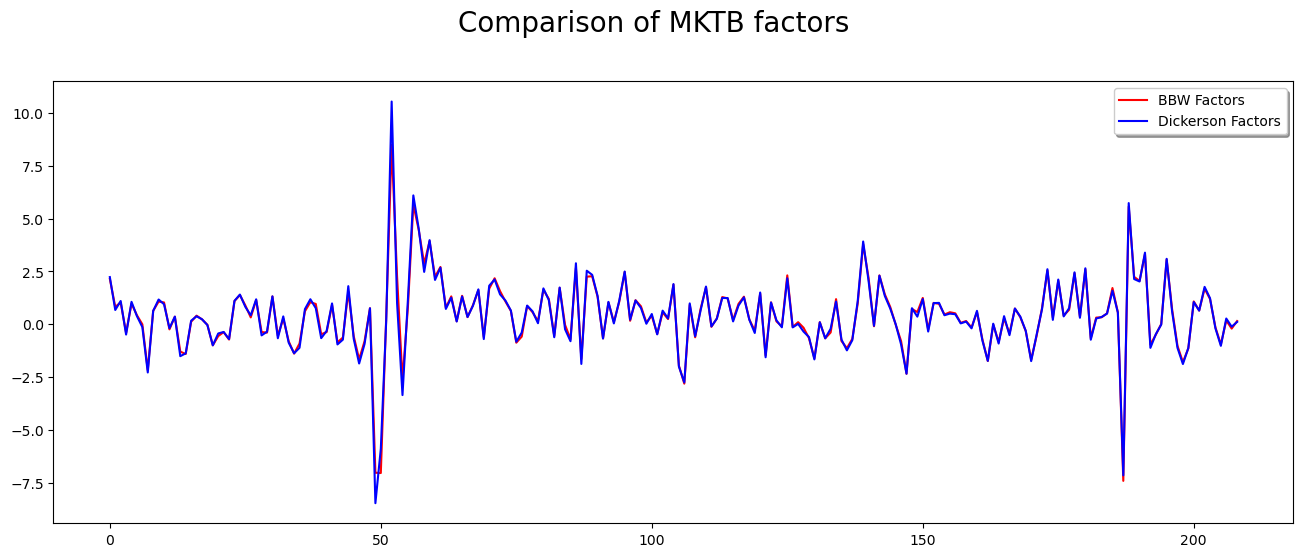

In [26]:
### Create a time series plot to compare the mktb factors

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of MKTB factors', fontsize=20)

ax1 = plt.subplot(211)
ax1.plot(regression_df['mktb'], 'r-', regression_df['mktb_alex'], 'b-')
ax1.legend(('BBW Factors','Dickerson Factors'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

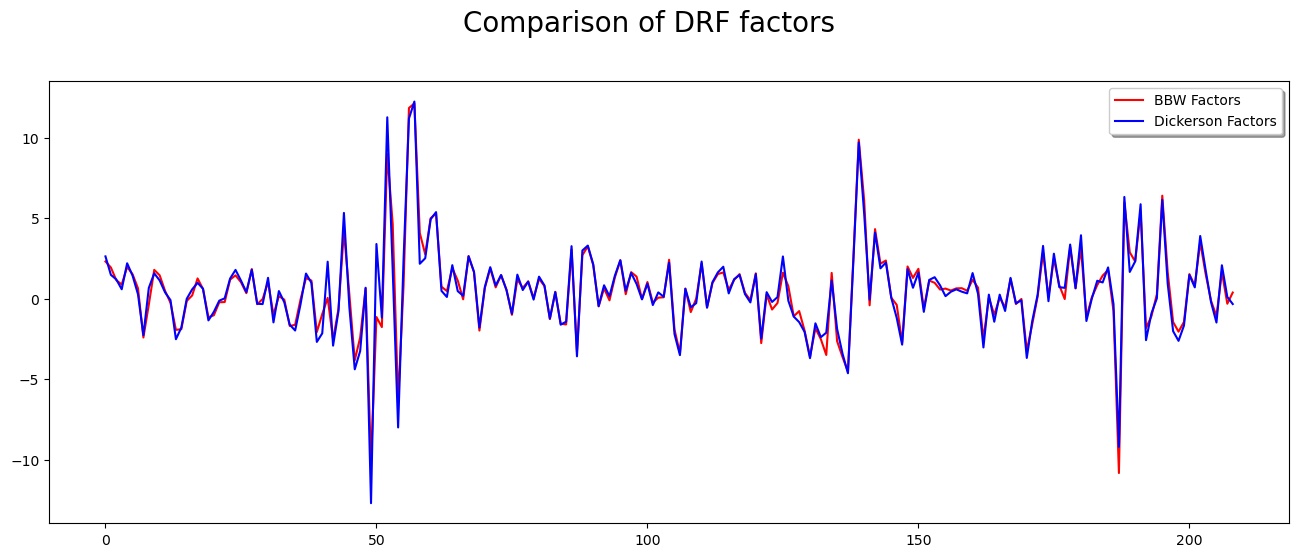

In [27]:
### Create a time series plot to compare the drf factors

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of DRF factors', fontsize=20)

ax1 = plt.subplot(211)
ax1.plot(regression_df['drf'], 'r-', regression_df['drf_alex'], 'b-')
ax1.legend(('BBW Factors','Dickerson Factors'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

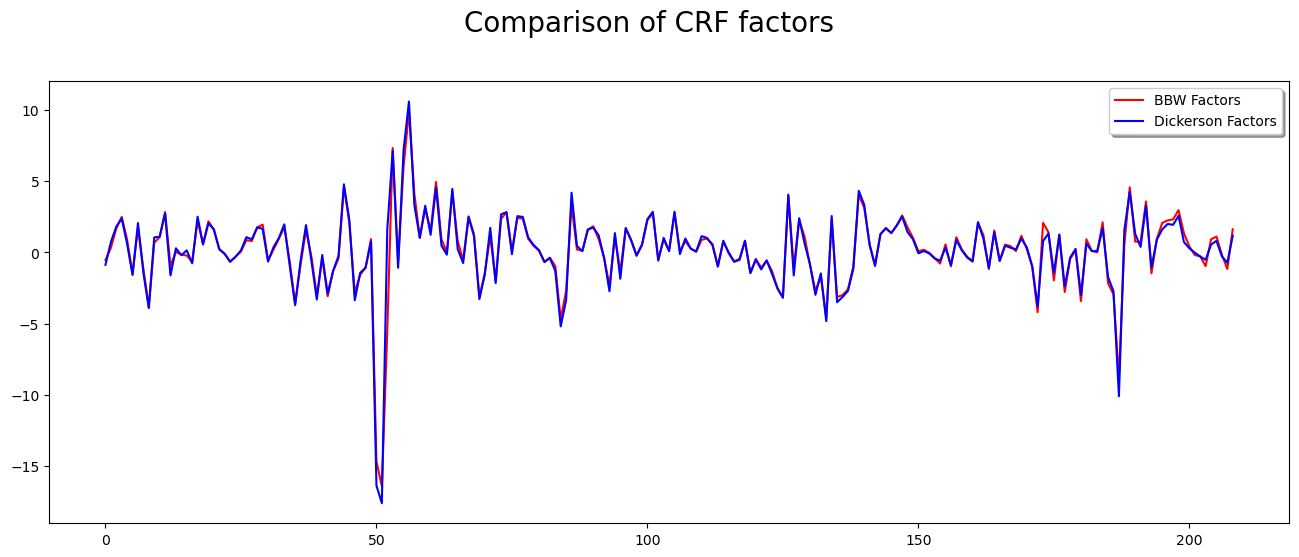

In [28]:
### Create a time series plot to compare the crf factors

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of CRF factors', fontsize=20)

ax1 = plt.subplot(211)
ax1.plot(regression_df['crf'], 'r-', regression_df['crf_alex'], 'b-')
ax1.legend(('BBW Factors','Dickerson Factors'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

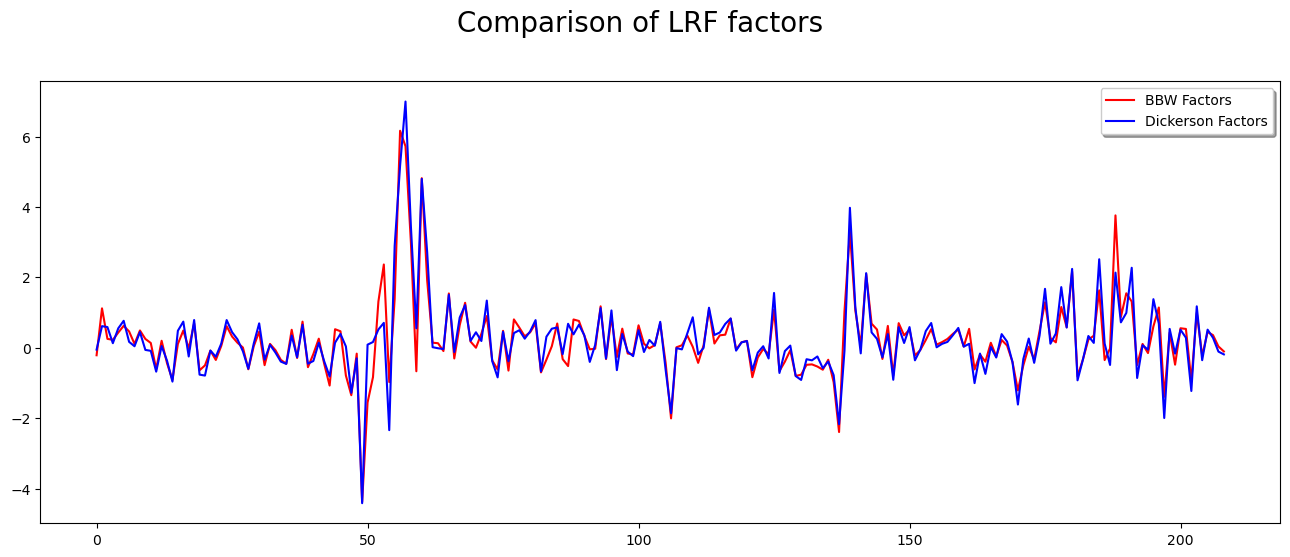

In [29]:
### Create a time series plot to compare the lrf factors

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of LRF factors', fontsize=20)

ax1 = plt.subplot(211)
ax1.plot(regression_df['lrf'], 'r-', regression_df['lrf_alex'], 'b-')
ax1.legend(('BBW Factors','Dickerson Factors'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

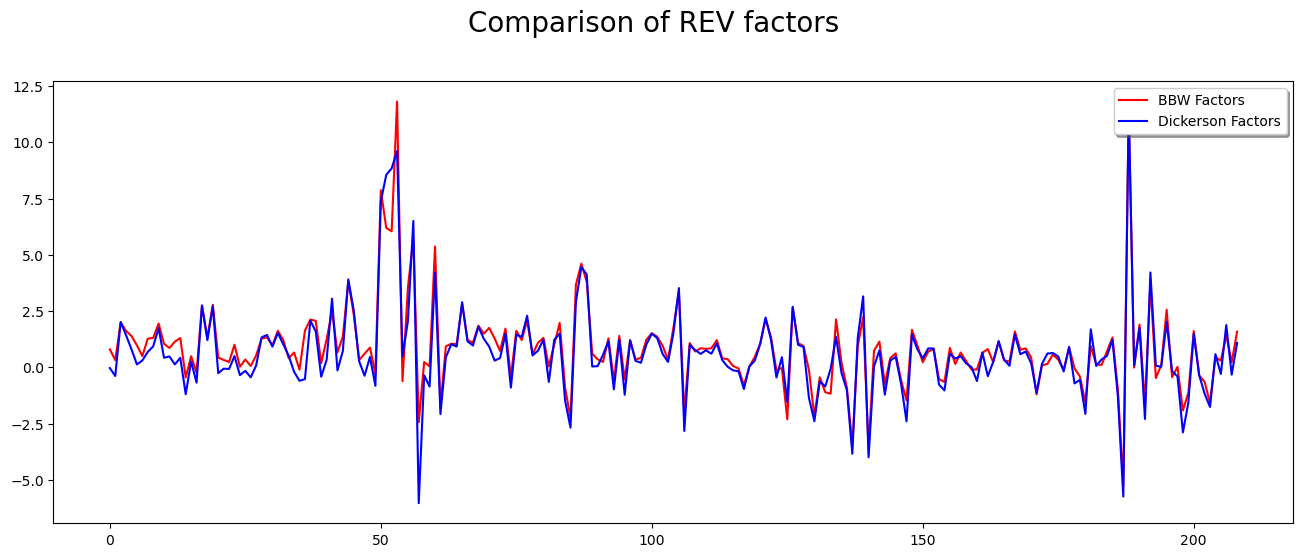

In [30]:
### Create a time series plot to compare the rev factors

plt.figure(figsize=(16,12))
plt.suptitle('Comparison of REV factors', fontsize=20)

ax1 = plt.subplot(211)
ax1.plot(regression_df['rev'], 'r-', regression_df['rev_alex'], 'b-')
ax1.legend(('BBW Factors','Dickerson Factors'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()